# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This dataset relates to 17 marketing campaigns conducted between May 2008 and November 2010. It includes data for a total of 79,354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score, roc_curve, precision_recall_curve, RocCurveDisplay, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import seaborn as sns
from sklearn.dummy import DummyClassifier
import warnings

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.



Input variables:

#### bank client data:
```
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
```

#### related with the last contact of the current campaign:
```
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
```

#### other attributes:
```
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
```

#### social and economic context attributes
```
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)
```

#### Output variable (desired target):
```
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
df = df.rename(columns = { 'y': 'subscribed' })

<Axes: >

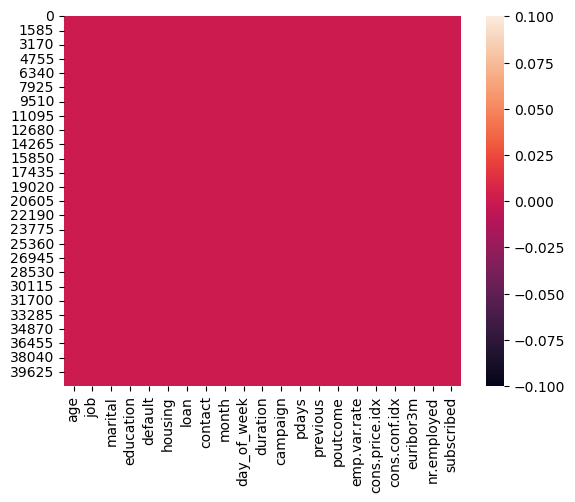

In [6]:
# Looking for missing values
sns.heatmap(
	df.isna()
)

# There is not null/empty values over this dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [8]:
# All the data looks with the right data type

##### Evaluating categorical columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'subscribed'],
      dtype='object')

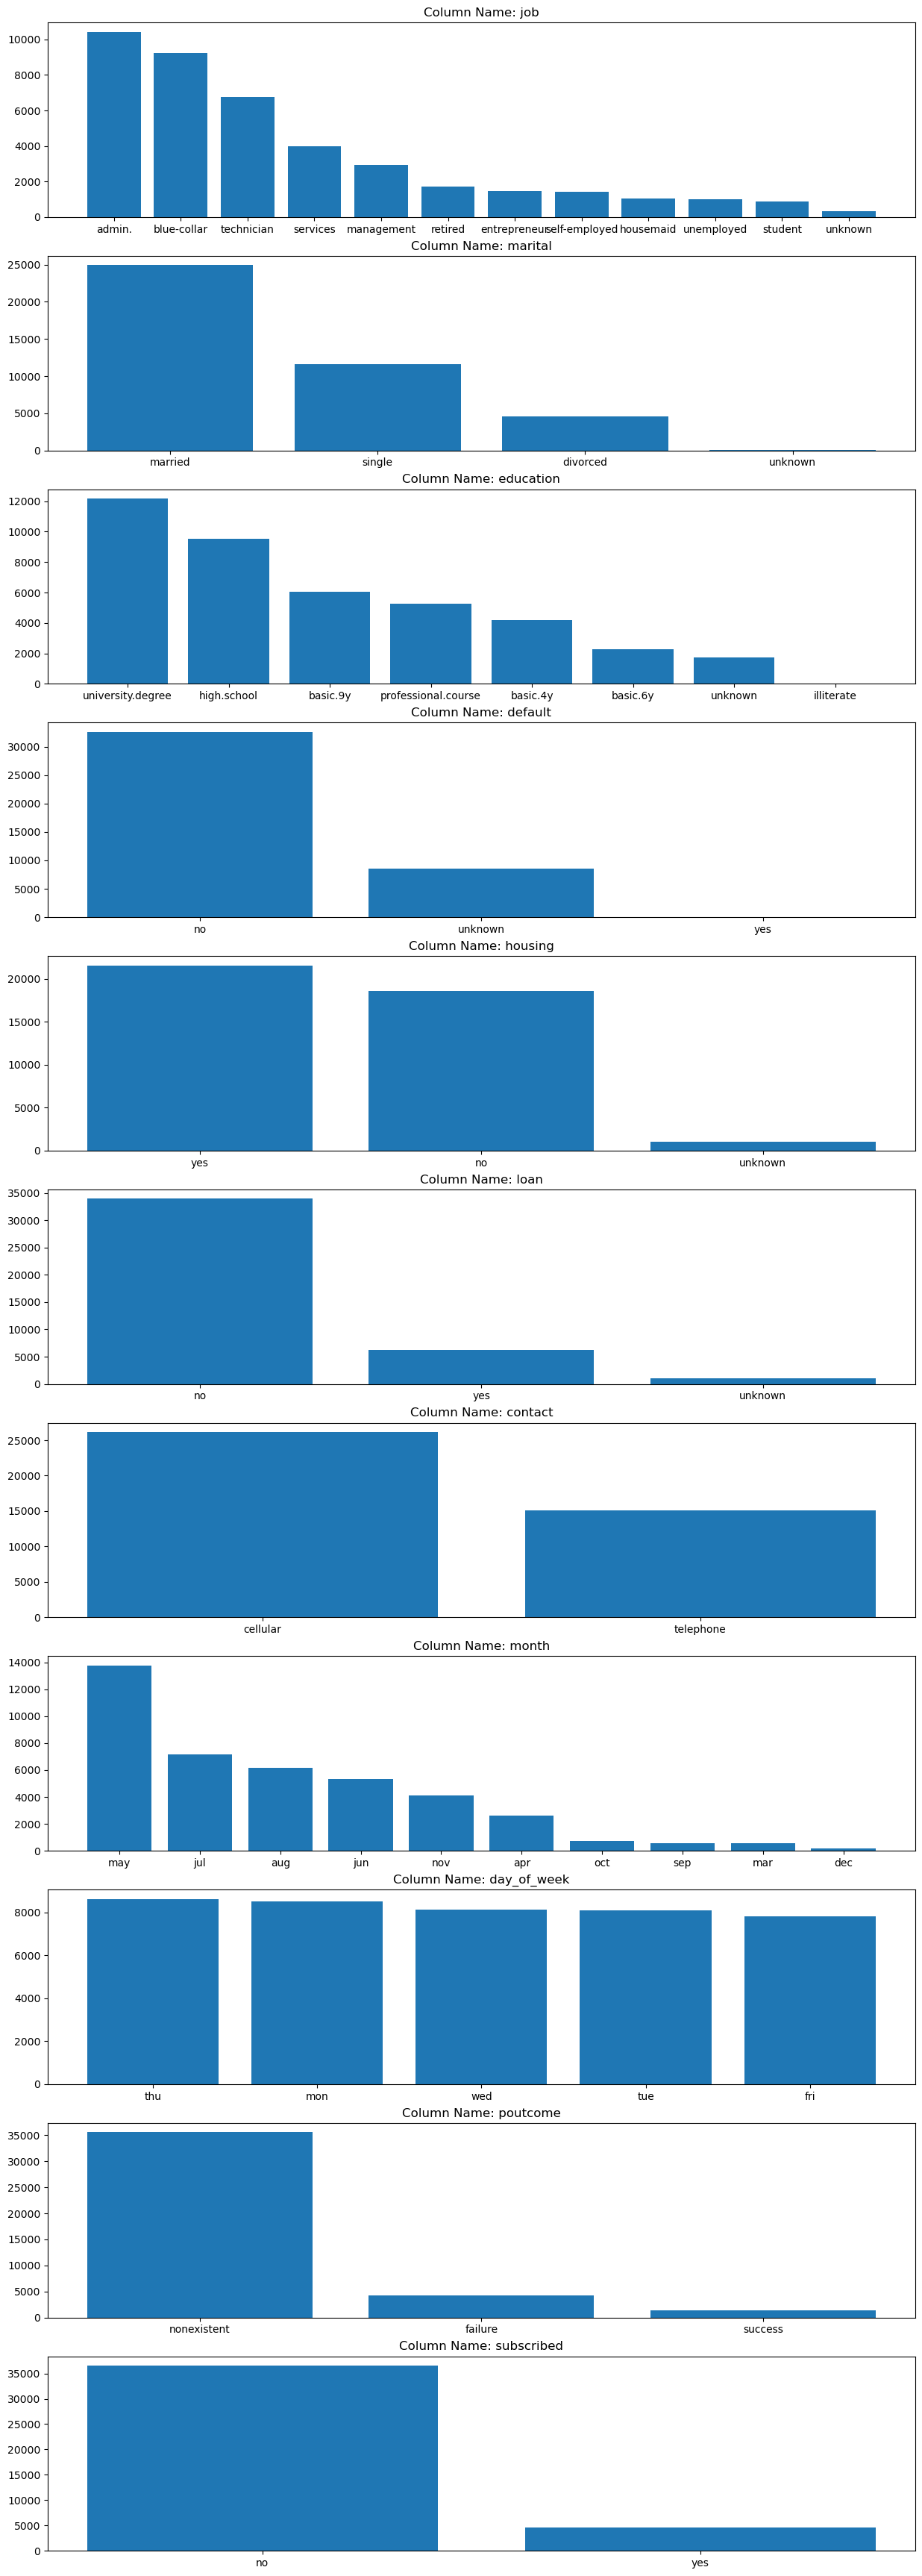

In [10]:
# Selecting categorical columns
categorical_columns = df.select_dtypes(include=object).columns
display(categorical_columns)

# Generating a subplots space to render a bar chart per column displaying the counts
fig, ax = plt.subplots(len(categorical_columns), 1, figsize = (15, 4 * len(categorical_columns)))  # Rows, Columns, Figure size

# Iterating each column
for i, column_name in enumerate(categorical_columns):
  df_column = df[column_name].value_counts().reset_index()
  ax[i].bar(df_column[column_name], df_column['count']) 
  ax[i].set_title(f'Column Name: {column_name}')

In [73]:
print(categorical_columns)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The business objetive of this task is to identify which are the most relevant characteristics that influence a client to subscribe or not to a bank deposit account, at the same time that we can predict using these characteristics the clients' decision for its potential use in the segmentation of marketing campaigns, to improve the number of subscribed customers and obtain the greatest benefits in terms of return on investment on said campaigns.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [109]:
# Identifying bank information from provided DataSet
columns_bank_information = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'subscribed' ]

# New dataframe with bank information
df_bank_data = df.copy()[columns_bank_information]

# Converting to number the target column
df_bank_data['subscribed'] = np.where(df_bank_data['subscribed'] == 'yes', 1, 0)

df_bank_data.sample(10)


,age,job,marital,education,default,housing,loan,subscribed
34694,31,entrepreneur,married,university.degree,no,yes,no,0
26537,29,services,married,high.school,unknown,yes,yes,0
11469,37,admin.,married,high.school,unknown,yes,no,0
18843,58,blue-collar,married,basic.9y,no,no,no,0
40178,51,admin.,married,university.degree,no,no,yes,1
557,40,technician,married,basic.4y,no,no,no,0
32924,32,admin.,married,university.degree,no,yes,no,0
36244,41,admin.,married,university.degree,no,no,no,0
31034,44,management,divorced,university.degree,no,yes,no,0
30926,54,management,married,university.degree,no,yes,yes,0


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [256]:
# ALL Features except the target feature
X = df_bank_data.drop(['subscribed'], axis=1)
# Target feature subscribed
y = df_bank_data['subscribed']

# Split the data taking 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
display(X_train, y_train)

,age,job,marital,education,default,housing,loan
39075,29,admin.,married,university.degree,no,no,no
34855,29,technician,single,university.degree,no,no,no
7107,45,blue-collar,married,basic.6y,unknown,yes,no
31614,34,services,married,university.degree,no,no,no
34878,32,admin.,single,high.school,no,no,no
...,...,...,...,...,...,...,...
6265,58,retired,married,professional.course,unknown,no,no
11284,37,management,married,university.degree,no,no,no
38158,35,admin.,married,high.school,no,yes,no
860,40,management,married,university.degree,no,yes,no


39075    0
34855    0
7107     0
31614    0
34878    0
        ..
6265     0
11284    0
38158    1
860      0
15795    0
Name: subscribed, Length: 28831, dtype: int64

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

#### Defining Methods and global variables to use


In [298]:
# Categorical columns
categorical_columns = df_bank_data.select_dtypes(include=object).columns

features = df_bank_data.drop(['subscribed'], axis=1).columns

# Numeric columns
numeric_columns = df_bank_data.drop(categorical_columns, axis=1).columns
numeric_columns = numeric_columns.drop('subscribed')

column_transformer = make_column_transformer(
    (TargetEncoder(), categorical_columns),
    remainder='passthrough'
)


# Method to evaluate a pipeline extracting the interesting values
def score_classifier(classifier):

    pipeline = Pipeline([
        ('tranformer', column_transformer),
        ('stdscl', StandardScaler()),
        ('model', classifier)
    ])

    # Initial timestamp
    timestamp = time.time()
    #Fitting pipeline
    pipeline.fit(X_train, y_train)
    #Calculating fitting time
    elapsedTime = time.time() - timestamp   

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)  

    # Evaluating scores
    train_score_acc = accuracy_score(y_train, y_train_pred)
    test_score_acc = accuracy_score(y_test, y_test_pred)

    train_score_ps = precision_score(y_train, y_train_pred)
    test_score_ps = precision_score(y_test, y_test_pred)

    train_score_rs = recall_score(y_train, y_train_pred)
    test_score_rs = recall_score(y_test, y_test_pred)

    train_score_f1 = f1_score(y_train, y_train_pred)
    test_score_f1 = f1_score(y_test, y_test_pred)
  
    #returning data
    return train_score_acc, test_score_acc, train_score_ps, test_score_ps, train_score_rs, test_score_rs, train_score_f1, test_score_f1, elapsedTime


#### Evaluating baseline

In [299]:
# I'll be evaluating the baseline using a DummyClassifier as discussed in coding_activity_16.8
classifier = DummyClassifier(strategy="uniform")

# Getting the baseline scoring
train_acc_dummy, test_acc_dummy, train_ps_dummy, test_ps_dummy, train_rs_dummy, test_rs_dummy, train_f1_dummy, test_f1_dummy, fit_time_dummy = \
    score_classifier(classifier)
print("The Score of the DummyRegression for test is:    Accuracy: {:.4%}, Recall:{:.4%}".format(test_acc_dummy, train_rs_dummy))

The Score of the DummyRegression for test is:    Accuracy: 49.8422%, Recall:49.3694%


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [300]:
# Building for LogisticRegression
classifier = LogisticRegression(max_iter=10000)

# Getting the scoring for LogisticRegression classifier
train_acc_lr, test_acc_lr, train_ps_lr, test_ps_lr, train_rs_lr, test_rs_lr, train_f1_lr, test_f1_lr, fit_time_lr = \
    score_classifier(classifier)

### Problem 9: Score the Model

What is the accuracy of your model?

In [301]:
print("The Score of the LogisticRegression for test is:    Accuracy: {:.4%}, Recall:{:.4%}".format(test_acc_lr, train_rs_lr))

The Score of the LogisticRegression for test is:    Accuracy: 88.7594%, Recall:0.0000%


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### KNN

In [302]:
# Building a pipeline for KNN
classifier = KNeighborsClassifier()

# Getting the scoring for KNN classifier
train_acc_knn, test_acc_knn, train_ps_knn, test_ps_knn, train_rs_knn, test_rs_knn, train_f1_knn, test_f1_knn, fit_time_knn = \
    score_classifier(classifier)

#### Decision Tree

In [303]:
# Building a pipeline for Decision Tree
classifier = DecisionTreeClassifier()

# Getting the scoring for Decision Tree classifier
train_acc_dt, test_acc_dt, train_ps_dt, test_ps_dt, train_rs_dt, test_rs_dt, train_f1_dt, test_f1_dt, fit_time_dt = \
    score_classifier(classifier)

#### SVN

In [304]:
# Building a pipeline for SVN
classifier = SVC(probability=True, coef0=1, gamma='scale', kernel = 'rbf')

# Getting the scoring for SVN classifier
train_acc_svn, test_acc_svn, train_ps_svn, test_ps_svn, train_rs_svn, test_rs_svn, train_f1_svn, test_f1_svn, fit_time_svn = \
    score_classifier(classifier)

### Results Comparison

In [306]:
results_df = ''

res_dict = {
    'Model': ['KNN', 'Logistic Regression', 'SVN', 'Decision tree'],
    'Train Time': [fit_time_knn, fit_time_lr, fit_time_svn, fit_time_dt],
    'Train Accuracy': [train_acc_knn, train_acc_lr, train_acc_svn, train_acc_dt],
    'Test Accuracy': [test_acc_knn, test_acc_lr, test_acc_svn, test_acc_dt],
    'Train Presicion': [train_ps_knn, train_ps_lr, train_ps_svn, train_ps_dt],
    'Test Presicion': [test_ps_knn, test_ps_lr, test_ps_svn, test_ps_dt],
    'Train Recall': [train_rs_knn, train_rs_lr, train_rs_svn, train_rs_dt],
    'Test Recall': [test_rs_knn, test_rs_lr, test_rs_svn, test_rs_dt],
    'Train F1': [train_f1_knn, train_f1_lr, train_f1_svn, train_f1_dt],
    'Test F1': [test_f1_knn, test_f1_lr, test_f1_svn, test_f1_dt]
}
           
results_df = pd.DataFrame(res_dict)

display(results_df)

,Model,Train Time,Train Accuracy,Test Accuracy,Train Presicion,Test Presicion,Train Recall,Test Recall,Train F1,Test F1
0,KNN,0.052888,0.884950,0.880311,0.440647,0.310924,0.075361,0.053276,0.128710,0.090965
1,Logistic Regression,0.066629,0.887239,0.887594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,SVN,94.081750,0.887413,0.887675,1.000000,1.000000,0.001538,0.000720,0.003071,0.001439
3,Decision tree,0.103063,0.842704,0.823015,0.265693,0.166945,0.223931,0.143988,0.243031,0.154619


Text(0.5, 1.0, 'Fitting Time')

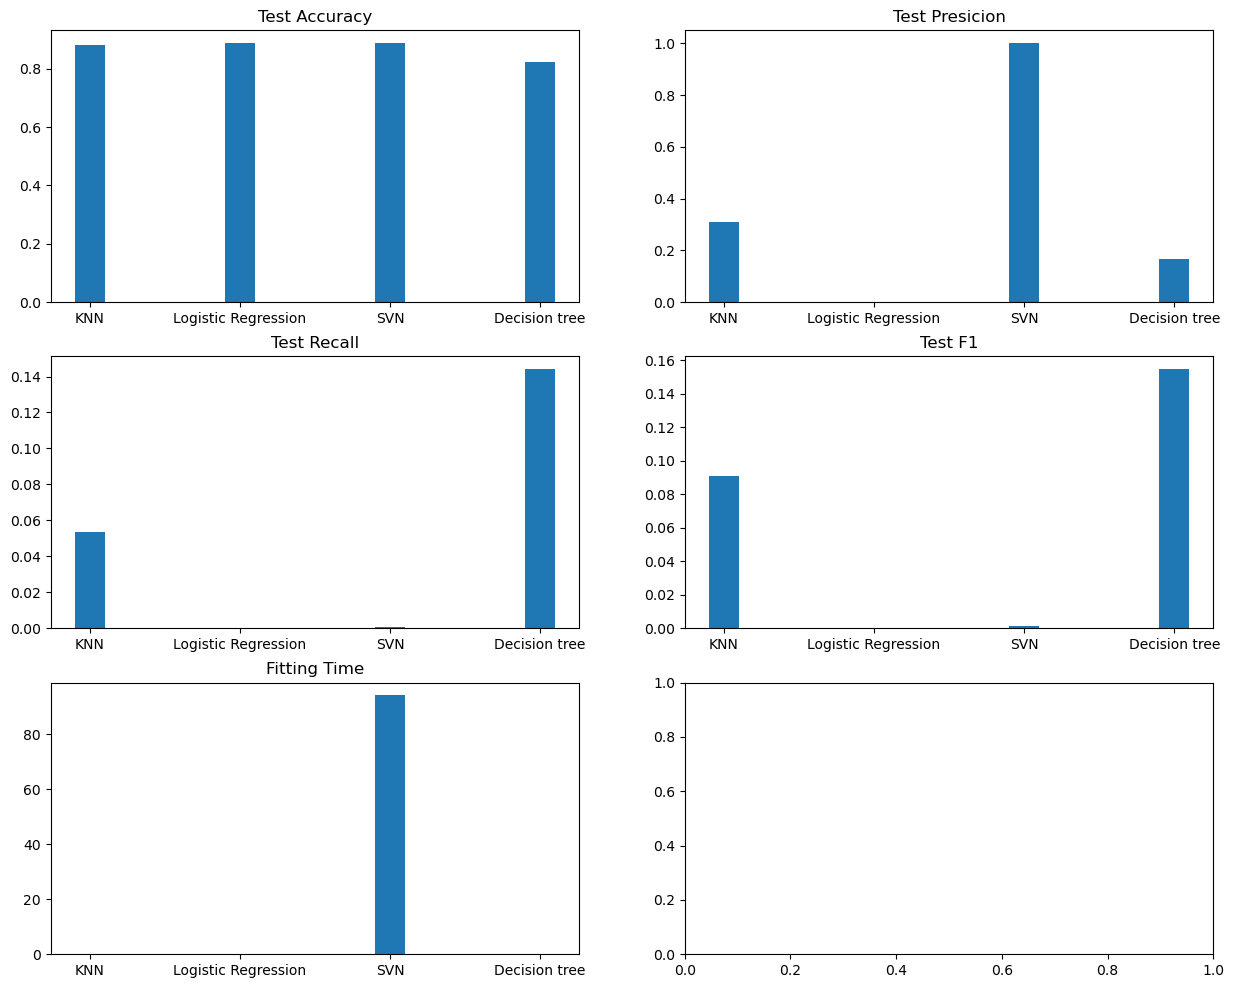

In [357]:
# Generating a subplots space to render a bar chart per column displaying the counts
fig, ax = plt.subplots(3, 2, figsize = (15, 12))  # Rows, Columns, Figure size

bar_width = 0.20
categories = results_df['Model']
ax[0][0].bar(categories, results_df['Test Accuracy'], bar_width, label = 'Accuracy')
ax[0][0].set_title('Test Accuracy')

ax[0][1].bar(categories, results_df['Test Presicion'], bar_width, label = 'Presicion')
ax[0][1].set_title('Test Presicion')

# ----
ax[1][0].bar(categories, results_df['Test Recall'], bar_width, label = 'Recall')
ax[1][0].set_title('Test Recall')

ax[1][1].bar(categories, results_df['Test F1'], bar_width, label = 'F1')
ax[1][1].set_title('Test F1')

# ----
ax[2][0].bar(categories, results_df['Train Time'], bar_width, label = 'Train Time')
ax[2][0].set_title('Fitting Time')


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### New Dataset

In [14]:
df_all = df.copy()


# Converting to number the target column
df_all['subscribed'] = np.where(df_all['subscribed'] == 'yes', 1, 0)

display(df_all.sample(10))

# ALL Features except the target feature
X = df_all.drop(['subscribed'], axis=1)
# Target feature subscribed
y = df_all['subscribed']

# Split the data taking 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
10906,38,blue-collar,married,basic.9y,unknown,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
33708,49,admin.,married,basic.4y,no,yes,no,cellular,may,wed,...,3,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,0
7246,50,blue-collar,married,basic.4y,unknown,no,no,telephone,may,thu,...,16,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
25588,36,self-employed,divorced,university.degree,no,yes,no,cellular,nov,wed,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,0
37276,27,student,single,high.school,no,no,no,cellular,aug,mon,...,1,3,2,success,-2.9,92.201,-31.4,0.884,5076.2,0
34485,31,blue-collar,married,basic.6y,no,yes,yes,cellular,may,thu,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,0
3425,26,unemployed,single,basic.9y,no,no,yes,telephone,may,thu,...,8,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
12308,32,housemaid,married,basic.6y,no,no,no,telephone,jul,fri,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,0
5614,45,admin.,married,basic.9y,no,no,no,telephone,may,mon,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3578,59,retired,divorced,basic.4y,no,yes,no,telephone,may,fri,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


#### Global methods to be used

In [15]:
# Categorical columns
categorical_columns = df_all.select_dtypes(include=object).columns

features = df_all.drop(['subscribed'], axis=1).columns

# Numeric columns
numeric_columns = df_all.drop(categorical_columns, axis=1).columns
numeric_columns = numeric_columns.drop('subscribed')

column_transformer = make_column_transformer(
    (TargetEncoder(), categorical_columns),
    remainder='passthrough'
)

# Method to evaluate a pipeline extracting the interesting values
def score_classifier_with_gscv(classifier, param_grid):

    pipeline = Pipeline([
        ('tranformer', column_transformer),
        ('stdscl', StandardScaler()),
        ('model', classifier)
    ])

    # Initial timestamp
    timestamp = time.time()

    #Fitting pipeline using GridSearchCV including params
    gscv = GridSearchCV(pipeline, param_grid=param_grid, scoring = 'accuracy')
    gscv.fit(X_train, y_train)

    #Calculating fitting time
    elapsedTime = time.time() - timestamp    

    y_train_pred = gscv.best_estimator_.predict(X_train)
    y_test_pred = gscv.best_estimator_.predict(X_test)  

    # Evaluating scores
    train_score_acc = accuracy_score(y_train, y_train_pred)
    test_score_acc = accuracy_score(y_test, y_test_pred)

    train_score_ps = precision_score(y_train, y_train_pred)
    test_score_ps = precision_score(y_test, y_test_pred)

    train_score_rs = recall_score(y_train, y_train_pred)
    test_score_rs = recall_score(y_test, y_test_pred)

    train_score_f1 = f1_score(y_train, y_train_pred)
    test_score_f1 = f1_score(y_test, y_test_pred)

    
    #returning data
    return train_score_acc, test_score_acc, train_score_ps, test_score_ps, train_score_rs, test_score_rs, train_score_f1, test_score_f1, elapsedTime, gscv.best_params_, gscv.best_score_



#### LogisticRegression

In [16]:
# Building a pipeline for LogisticRegression
classifier = LogisticRegression(max_iter=10000)

# Getting the scoring for LogisticRegression classifier
params_grid = {'model__C': np.logspace(-5, .5)}
train_acc_lr, test_acc_lr, train_ps_lr, test_ps_lr, train_rs_lr, test_rs_lr, train_f1_lr, test_f1_lr, fit_time_lr, best_params_lr, best_score_lr = \
    score_classifier_with_gscv(classifier, params_grid)

#### KNN

In [17]:
# Building a pipeline for KNN
classifier = KNeighborsClassifier()

# Getting the scoring for LogisticRegression classifier
params_grid = {'model__n_neighbors': range(5, 22, 2)}
train_acc_knn, test_acc_knn, train_ps_knn, test_ps_knn, train_rs_knn, test_rs_knn, train_f1_knn, test_f1_knn, fit_time_knn, best_params_knn, best_score_knn = \
    score_classifier_with_gscv(classifier, params_grid)

#### Decision Tree

In [18]:
# Building a pipeline for Decision Tree
classifier = DecisionTreeClassifier()

# Getting the scoring for Decision Tree classifier
params_grid = {'model__max_depth': [1,2,3,4,5,6,7,8],
    'model__min_samples_split': [2,4,6,8],
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_leaf': [1,2,4,6]
}
train_acc_dt, test_acc_dt, train_ps_dt, test_ps_dt, train_rs_dt, test_rs_dt, train_f1_dt, test_f1_dt, fit_time_dt, best_params_dt, best_score_dt = \
    score_classifier_with_gscv(classifier, params_grid)

#### SVN

In [19]:
# Building a pipeline for SVN
classifier = SVC()

# Getting the scoring for SVN classifier
params_grid = {'model__degree' : [2,3,4]}
train_acc_svn, test_acc_svn, train_ps_svn, test_ps_svn, train_rs_svn, test_rs_svn, train_f1_svn, test_f1_svn, fit_time_svn, best_params_svn, best_score_svn = \
    score_classifier_with_gscv(classifier, params_grid)

### Evaluating Results

In [20]:
results_df2 = ''

res_dict2 = {
    'Model': ['KNN', 'Logistic Regression', 'SVN', 'Decision tree'],
    'Train Time': [fit_time_knn, fit_time_lr, fit_time_svn, fit_time_dt],
    'Train Accuracy': [train_acc_knn, train_acc_lr, train_acc_svn, train_acc_dt],
    'Test Accuracy': [test_acc_knn, test_acc_lr, test_acc_svn, test_acc_dt],
    'Train Presicion': [train_ps_knn, train_ps_lr, train_ps_svn, train_ps_dt],
    'Test Presicion': [test_ps_knn, test_ps_lr, test_ps_svn, test_ps_dt],
    'Train Recall': [train_rs_knn, train_rs_lr, train_rs_svn, train_rs_dt],
    'Test Recall': [test_rs_knn, test_rs_lr, test_rs_svn, test_rs_dt],
    'Train F1': [train_f1_knn, train_f1_lr, train_f1_svn, train_f1_dt],
    'Test F1': [test_f1_knn, test_f1_lr, test_f1_svn, test_f1_dt]
}
           
results_df2 = pd.DataFrame(res_dict2)

display(results_df2)

,Model,Train Time,Train Accuracy,Test Accuracy,Train Presicion,Test Presicion,Train Recall,Test Recall,Train F1,Test F1
0,KNN,7.791151,0.911380,0.904993,0.683544,0.634207,0.398647,0.365731,0.503594,0.463927
1,Logistic Regression,33.645137,0.909507,0.910415,0.664447,0.672372,0.398954,0.395968,0.498559,0.498414
2,SVN,57.665585,0.920225,0.911063,0.747527,0.673445,0.441710,0.405328,0.555298,0.506067
3,Decision tree,118.775304,0.917068,0.915756,0.656820,0.655914,0.553983,0.526998,0.601035,0.584431


#### Graphical View

Text(0.5, 1.0, 'Fitting Time GSCV')

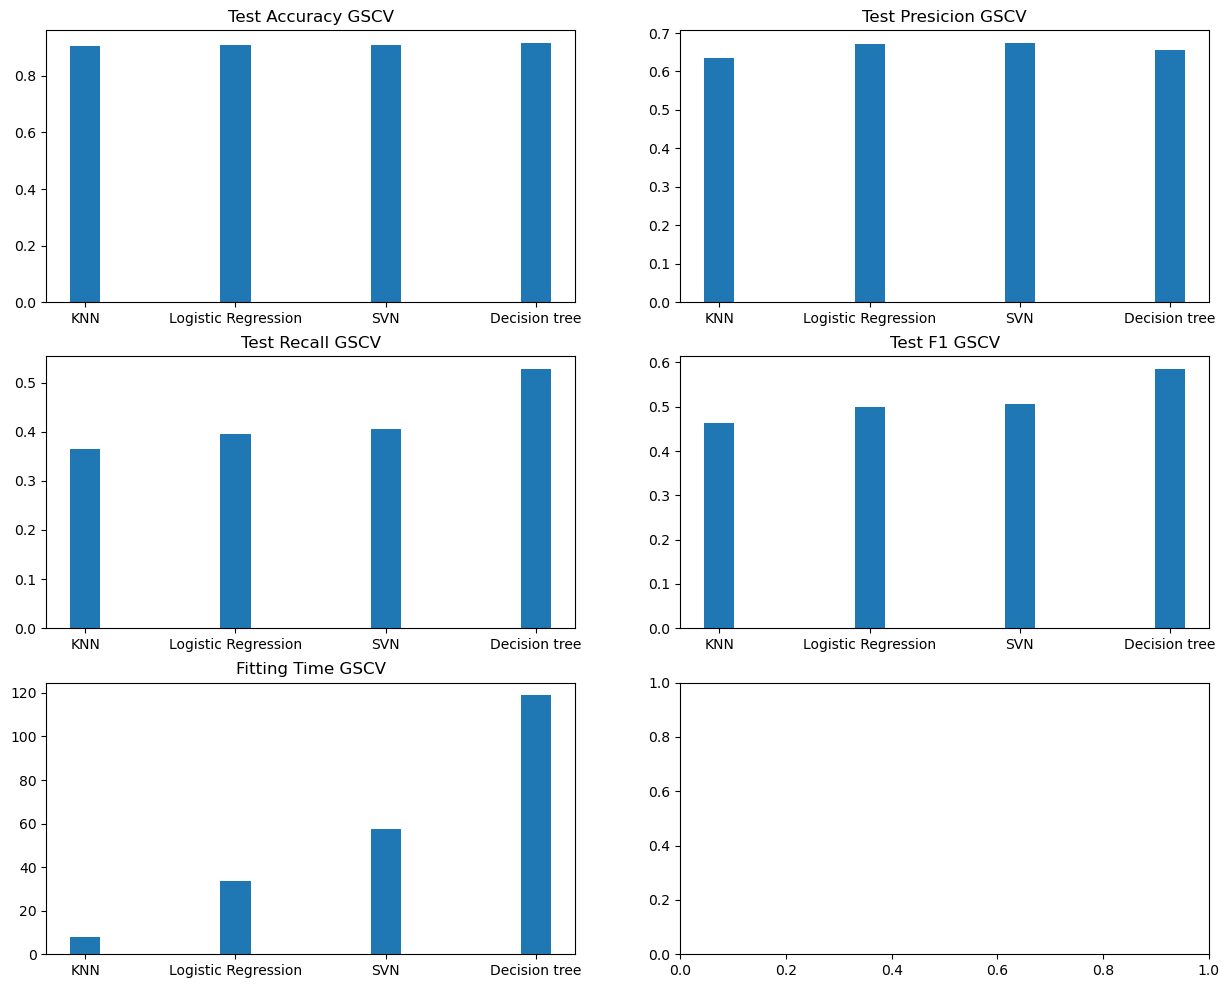

In [21]:
# Generating a subplots space to render a bar chart per column displaying the counts
fig, ax = plt.subplots(3, 2, figsize = (15, 12))  # Rows, Columns, Figure size

bar_width = 0.20
categories = results_df2['Model']
ax[0][0].bar(categories, results_df2['Test Accuracy'], bar_width, label = 'Accuracy')
ax[0][0].set_title('Test Accuracy GSCV')

ax[0][1].bar(categories, results_df2['Test Presicion'], bar_width, label = 'Presicion')
ax[0][1].set_title('Test Presicion GSCV')

# ----
ax[1][0].bar(categories, results_df2['Test Recall'], bar_width, label = 'Recall')
ax[1][0].set_title('Test Recall GSCV')

ax[1][1].bar(categories, results_df2['Test F1'], bar_width, label = 'F1')
ax[1][1].set_title('Test F1 GSCV')

# ----
ax[2][0].bar(categories, results_df2['Train Time'], bar_width, label = 'Train Time')
ax[2][0].set_title('Fitting Time GSCV')


#### Results
Based on the above results, the evaluation using the GridSearchCSV doesn't improve significatively the performance of the model. Considering the fitting time and the accuracy score, the KNN is the best option for the business predictions.


#### Permutation Importance

Evaluating what are the most relevant features to use

In [22]:
# Evaluating what are the most important features.
scoring = [ 'neg_mean_squared_error']

classifier = KNeighborsClassifier()

# Getting the scoring for LogisticRegression classifier
params_grid = {'model__n_neighbors': range(5, 22, 2)}

pipeline = Pipeline([
        ('tranformer', column_transformer),
        ('stdscl', StandardScaler()),
        ('model', classifier)
])  

#Fitting pipeline using GridSearchCV including params
gscv = GridSearchCV(pipeline, param_grid=params_grid, scoring = 'accuracy')
gscv.fit(X_train, y_train)

# I'm using the best model and the best estimator obtained by this
r_multi = permutation_importance(
            gscv.best_estimator_, 
            X_test, 
            y_test, 
            n_repeats=30, 
            random_state=21, 
            scoring=scoring
    )

In [26]:
importances_tr = dict(
        zip(
                X_train.columns, 
                r_multi['neg_mean_squared_error'].importances_mean
        )
)
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}
import_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Importances']).reset_index().sort_values(['Importances'], ascending=False)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'month'),
  Text(1, 0, 'duration'),
  Text(2, 0, 'pdays'),
  Text(3, 0, 'contact'),
  Text(4, 0, 'nr.employed'),
  Text(5, 0, 'cons.conf.idx'),
  Text(6, 0, 'previous'),
  Text(7, 0, 'day_of_week'),
  Text(8, 0, 'poutcome'),
  Text(9, 0, 'cons.price.idx'),
  Text(10, 0, 'default'),
  Text(11, 0, 'campaign'),
  Text(12, 0, 'euribor3m'),
  Text(13, 0, 'education'),
  Text(14, 0, 'loan'),
  Text(15, 0, 'job'),
  Text(16, 0, 'emp.var.rate'),
  Text(17, 0, 'marital'),
  Text(18, 0, 'housing'),
  Text(19, 0, 'age')])

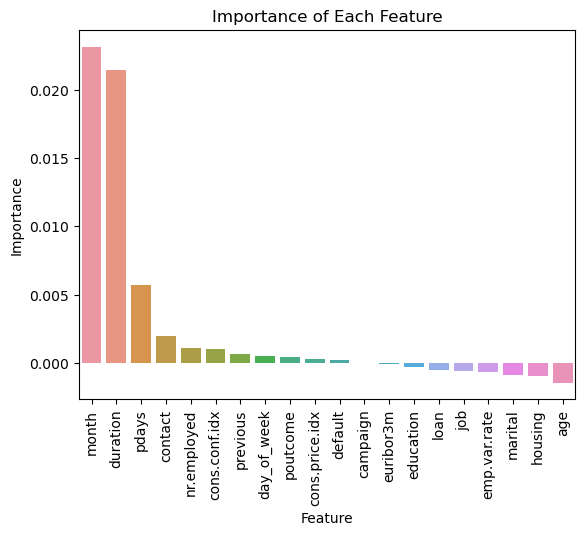

In [28]:
# Visualization of the importance of each feature vs the price
sns.barplot(data = import_df, x="index", y="Importances")

plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title('Importance of Each Feature')
plt.xticks(rotation=90)  # Rotate labels by 45 degrees

In [31]:
# ALL Features except the target feature
X = df_all[['month', 'duration', 'pdays', 'contact', 'nr.employed', 'cons.conf.idx']]
# Target feature subscribed
y = df_all['subscribed']

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          41188 non-null  object 
 1   duration       41188 non-null  int64  
 2   pdays          41188 non-null  int64  
 3   contact        41188 non-null  object 
 4   nr.employed    41188 non-null  float64
 5   cons.conf.idx  41188 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.9+ MB


In [35]:


# Split the data taking 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building a pipeline for KNN
classifier = KNeighborsClassifier()

column_transformer = make_column_transformer(
    (TargetEncoder(), ['month', 'contact']),
    remainder='passthrough'
)

# Getting the scoring for LogisticRegression classifier
param_grid = {'model__n_neighbors': range(5, 22, 2)}


pipeline = Pipeline([
        ('tranformer', column_transformer),
        ('stdscl', StandardScaler()),
        ('model', classifier)
    ])

# Initial timestamp
timestamp = time.time()

#Fitting pipeline using GridSearchCV including params
gscv = GridSearchCV(pipeline, param_grid=param_grid, scoring = 'accuracy')
gscv.fit(X_train, y_train)

#Calculating fitting time
elapsedTime = time.time() - timestamp    

y_train_pred = gscv.best_estimator_.predict(X_train)
y_test_pred = gscv.best_estimator_.predict(X_test)  

# Evaluating scores
train_score_acc = accuracy_score(y_train, y_train_pred)
test_score_acc = accuracy_score(y_test, y_test_pred)

train_score_ps = precision_score(y_train, y_train_pred)
test_score_ps = precision_score(y_test, y_test_pred)

train_score_rs = recall_score(y_train, y_train_pred)
test_score_rs = recall_score(y_test, y_test_pred)

train_score_f1 = f1_score(y_train, y_train_pred)
test_score_f1 = f1_score(y_test, y_test_pred)


In [36]:
print(f'Test Accuracy Score: { test_acc_knn }')
print(f'Fitting time: { elapsedTime }')

Test Accuracy Score: 0.9049931213077608
Fitting time: 7.318727016448975


### Correlation


[Text(0.5, 1.0, 'Correlation Heatmap')]

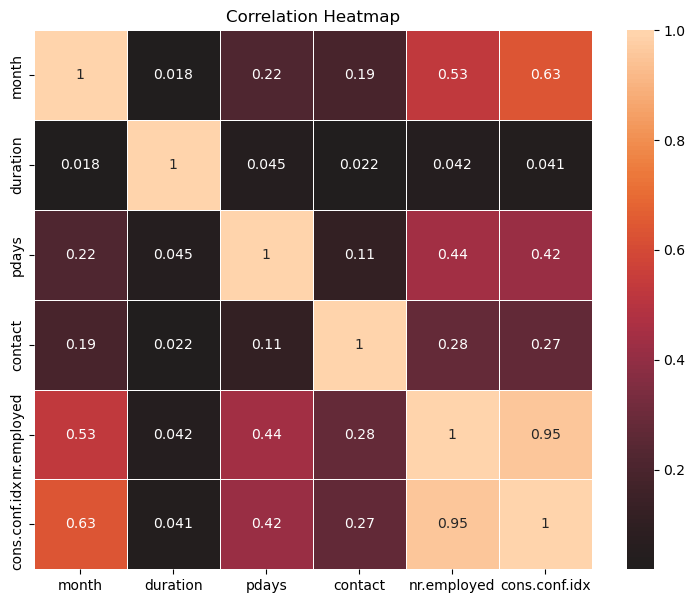

In [75]:
# Correlation using the TOP 5 features identified as most important
# df_all[['month', 'duration', 'pdays', 'contact', 'nr.employed', 'cons.conf.idx']]
features_importance = ['month', 'duration', 'pdays', 'contact', 'nr.employed', 'cons.conf.idx']
target_encoder = TargetEncoder()
df_target_encoded = pd.DataFrame(target_encoder.fit_transform(df_all[features_importance], df_all["subscribed"]), columns=features_importance)


f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(df_target_encoded.corr(), 
    center = 0, 
    linewidth = .7, 
    annot = True
).set(title='Correlation Heatmap')

##### Questions